In [6]:
import sys
sys.path.append("..")
from dotenv import load_dotenv
load_dotenv()

import omeka_extractor as oe
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import utils as ou
metadata_categories = ou.load_yaml('../metadata_categories.yaml')
metadata_categories_global = ou.load_yaml('../metadata_categories_global.yaml')
categories_metadata = ou.reverse_yaml(metadata_categories)
categories_metadata_global = ou.reverse_yaml(metadata_categories_global)

In [9]:
metadata_df = pd.read_csv('../data/metadata_df.csv')

In [10]:
metadata_df["element__category"] = metadata_df["element__name"].map(categories_metadata)
metadata_df["element__category__global"] = metadata_df["element__name"].map(categories_metadata_global)

In [11]:
metadata_categorised = metadata_df[['id', 'item_type__name', 'element__name', 'element__category', 'text']]

In [12]:
# Num of unique items per item type
metadata_df[['id', 'item_type__name']].drop_duplicates()['item_type__name'].value_counts()

item_type__name
Still Image          287
Text Item            111
Contextual Item      104
Landscape Item        92
Viewpoint             54
Physical Object       32
Biographical Text     24
Exhibit Metadata      16
Oral History          15
Moving Image           2
Sound                  2
Background Panel       1
Name: count, dtype: int64

### Items with text metadata

In [13]:
omeka_text = metadata_categorised[metadata_categorised['element__category'] == "Content Description (English)"]

In [14]:
# Count metadata length
omeka_text['word_count'] = omeka_text['text'].str.split().apply(len)
omeka_text['text_length'] = omeka_text['text'].str.len()

/tmp/ipykernel_854232/4026513723.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omeka_text['word_count'] = omeka_text['text'].str.split().apply(len)
/tmp/ipykernel_854232/4026513723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  omeka_text['text_length'] = omeka_text['text'].str.len()


In [15]:
omeka_text_filtered = omeka_text.loc[omeka_text.groupby('id')['text_length'].apply(lambda x: x.idxmax())]

In [16]:
omeka_text_filtered['item_type__name'].value_counts()

item_type__name
Still Image          280
Text Item            109
Contextual Item      104
Landscape Item        92
Physical Object       30
Biographical Text     22
Exhibit Metadata      16
Oral History          15
Moving Image           1
Sound                  1
Name: count, dtype: int64

#### Images

In [17]:
# How many items are images?
omeka_images = omeka_text_filtered[omeka_text_filtered['item_type__name'] == 'Still Image']
print(f"Number of image items: {len(omeka_images)}")

# How many of these images have text descriptions with > 100 chars?
omeka_images_100 = omeka_images[omeka_images['text_length'] > 100]
print(f"Number of image items with > 100 chars: {len(omeka_images_100)}")

Number of image items: 280
Number of image items with > 100 chars: 97


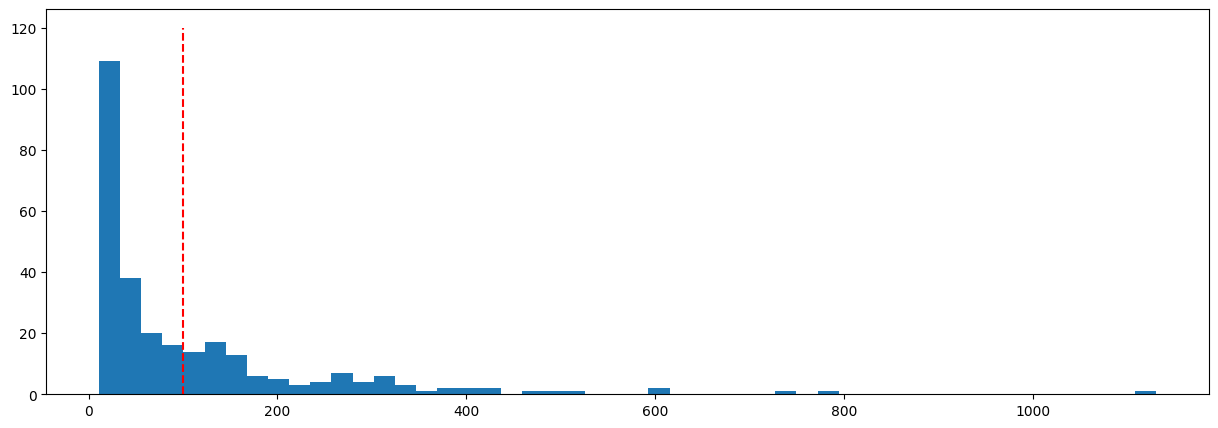

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.hist(omeka_images['text_length'], bins=50)
plt.vlines(100, 0, 120, colors='r', linestyles='dashed');

In [18]:
omeka_images['text_length'].describe()

count     280.000000
mean      108.489286
std       139.761625
min        11.000000
25%        21.000000
50%        49.500000
75%       144.000000
max      1130.000000
Name: text_length, dtype: float64

#### Text / Diaries ...

In [23]:
omeka_descriptions = omeka_text_filtered[omeka_text_filtered['item_type__name'].isin(['Contextual Item', 'Text Item'])]

In [26]:
# How many of these items have text descriptions with > 100 chars?
omeka_descriptions_100 = omeka_descriptions[omeka_descriptions['text_length'] > 100]
print(f"Number of text/diary items with > 100 chars: {len(omeka_descriptions_100)}")

Number of text/diary items with > 100 chars: 206


In [46]:
example_nonimage = 846

## Print title
print("Title\n-----\n", omeka_text[omeka_text['id'] == example_nonimage][['item_type__name', 'text']]['text'].values[0])

## Print text
print("\nText\n----\n", omeka_text[omeka_text['id'] == example_nonimage][['item_type__name', 'text']]['text'].values[1])


Title
-----
 The Camp's Main Street

Text
----
 The camp’s main street, a six-metre-wide sand track, was built in 1941 during the expansion of the POW camp. It lay at the centre of the 70-metre-wide area between the huts for POWs and those for concentration camp prisoners. This part of the camp also contained facilities such as kitchens, fire water reservoirs and food depots. The main street was under permanent watch by the guards. Camp inmates were only allowed to use it on work assignments during the day and had to be accompanied by guards.


In [48]:
example_nonimage = 841

## Print title
print("Title\n-----\n", omeka_text[omeka_text['id'] == example_nonimage][['item_type__name', 'text']]['text'].values[0])

## Print text
print("\nText\n----\n", omeka_text[omeka_text['id'] == example_nonimage][['item_type__name', 'text']]['text'].values[1])

Title
-----
 The Men's Camp

Text
----
 The first transport with 1,000 sick prisoners arrived in Bergen-Belsen on 27 March 1944. The evacuation transports brought people from all countries occupied by the Germans to Bergen-Belsen concentration camp. The majority of the prisoners in the camp came from Poland, Hungary and the Soviet Union. The largest groups were the political prisoners and those who were persecuted based on the racist National-Socialist ideology, especially Jews, Sinti and Roma. 
